In [1]:
import torch
from diffusers import StableDiffusionGLIGENPipeline
from diffusers.utils import load_image
from compel import Compel
import numpy as np
import cv2
import matplotlib.pyplot as plt


#  Generation Model Initialization
pipe = StableDiffusionGLIGENPipeline.from_pretrained(
    "masterful/gligen-1-4-inpainting-text-box", 
    variant="fp16", 
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda:0")
compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
generator = torch.Generator(device='cuda:0').manual_seed(777)

# 시각화 함수
def visualization(input_image, generated_image, boxes):
    np_input = np.array(input_image)
    np_genai = np.array(generated_image)
    np_genai_copy = np_genai.copy()
    height, width, _ = np_genai.shape

    for box in boxes:
        min_x, min_y, max_x, max_y = box
        min_x = int(min_x * width)
        min_y = int(min_y * height)
        max_x = int(max_x * width)
        max_y = int(max_y * height)
        cv2.rectangle(np_genai_copy, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)

    plt.imshow(np_genai_copy)
    plt.axis('off')
    plt.show()

/home/work/.conda/envs/main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:00,  8.90it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c8be3/vae: Error no file named diffusion_pytorch_model.fp16.safetensors found in directory /home/work/.cache/huggingface/hub/models--masterful--gligen-1-4-inpainting-text-box/snapshots/d6d957f8d27c40889c0d570a616571a5645c8be3/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  6.36it/s]/home/work/.conda/envs/main/lib/python3.12/site-packages/transformers/models/clip/feature_extra

# Prompt 실험

Text Prompt로 Style 관련 프롬프트를 넣었을 때, 이미지를 잘 생성할 수 있는지에 대한 실험

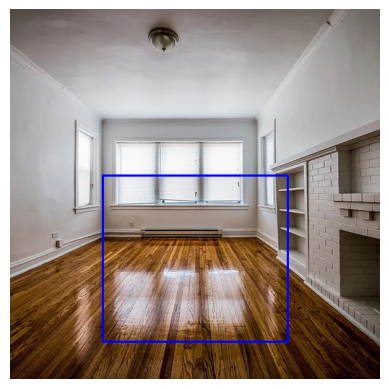

In [2]:
from PIL import Image

def _target_center_crop_and_resize(image):
    width, height = image.size
    crop_size = min(width, height)
    x1, y1 = (width - crop_size) // 2, (height - crop_size) // 2
    x2, y2 = (width + crop_size) // 2, (height + crop_size) // 2
    image = image.crop((x1, y1, x2, y2))
    image = image.resize((512, 512), Image.LANCZOS)
    return image

input_image = Image.open("./bg-for-prompt-test.jpeg").convert('RGB')
input_image = _target_center_crop_and_resize(input_image)
boxes        = [[0.25, 0.45, 0.75, 0.9]]

np_input = np.array(input_image)
height, width, _ = np_input.shape

for box in boxes:
    min_x, min_y, max_x, max_y = box
    min_x = int(min_x * width)
    min_y = int(min_y * height)
    max_x = int(max_x * width)
    max_y = int(max_y * height)
    cv2.rectangle(np_input, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)

plt.imshow(np_input)
plt.axis('off')
plt.show()

### 1. Prompt : A Bed

/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:747: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  if gligen_inpaint_image.size != (self.vae.sample_size, self.vae.sample_size):
/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:748: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  gligen_inpaint_image = self.target_size_center_crop(gligen_inpaint_image, self.vae.sample_size)
100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


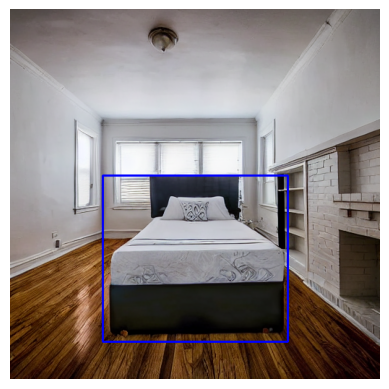

In [3]:
input_image  = load_image("./bg-for-prompt-test.jpeg")
boxes        = [[0.25, 0.45, 0.75, 0.9]]
phrases      = ["a bed"]
prompt       = "a bed"

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

### 2. Prompt : best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution

100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


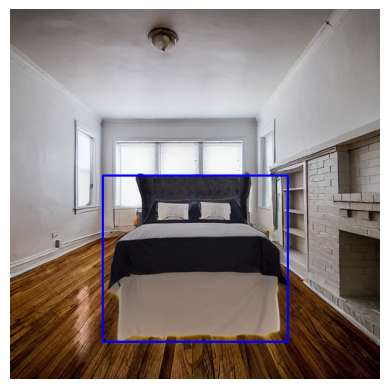

In [4]:
input_image  = load_image("./bg-for-prompt-test.jpeg")
boxes        = [[0.25, 0.45, 0.75, 0.9]]
phrases      = ["a bed"]
prompt       = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

### 3. Prompt : Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones

100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


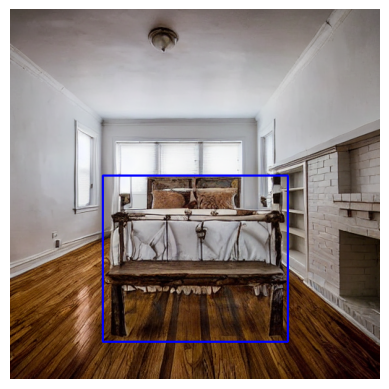

In [ ]:
input_image  = load_image("./bg-for-prompt-test.jpeg")
boxes        = [[0.25, 0.45, 0.75, 0.9]]
phrases      = ["a bed"]
prompt       = "Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones"

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

generator = torch.Generator(device='cuda:0').manual_seed(777)

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

# Style Prompt 실험 (객체 3개)

단일 객체가 아닌, 다중 객체가 되어도 이미지가 제대로 생성되는지 실험.

이때, 단일 문장형 프롬프트가 아닌 다중 문장형 프롬프트 사용. 즉, 각각의 프롬프트에서 Embedding Vector를 추출한 후 이어붙이는 방법을 사용. 이 방법을 사용할 경우, 각 프롬프트 별 정보가 독립적이게 되어 세부 정보를 더 잘 표현할 수 있음

ex) Compel Lib. 사용
```python
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"
prompt_style   = "Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones"
prompt         = f'("{prompt_default}", "{prompt_style}"+).and()'
```

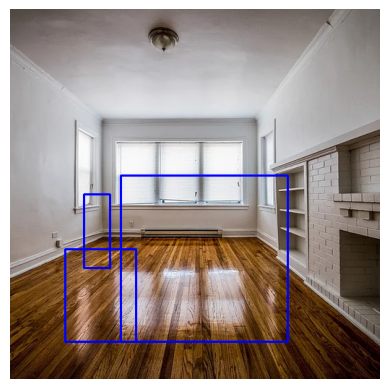

In [6]:
from PIL import Image

def _target_center_crop_and_resize(image):
    width, height = image.size
    crop_size = min(width, height)
    x1, y1 = (width - crop_size) // 2, (height - crop_size) // 2
    x2, y2 = (width + crop_size) // 2, (height + crop_size) // 2
    image = image.crop((x1, y1, x2, y2))
    image = image.resize((512, 512), Image.LANCZOS)
    return image

input_image = Image.open("./bg-for-prompt-test.jpeg").convert('RGB')
input_image = _target_center_crop_and_resize(input_image)
boxes        = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases      = ["a dresser", "a lamp", "blue bed"]

np_input = np.array(input_image)
height, width, _ = np_input.shape

for box in boxes:
    min_x, min_y, max_x, max_y = box
    min_x = int(min_x * width)
    min_y = int(min_y * height)
    max_x = int(max_x * width)
    max_y = int(max_y * height)
    cv2.rectangle(np_input, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)

plt.imshow(np_input)
plt.axis('off')
plt.show()

### 1. Rustic (Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones)

100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


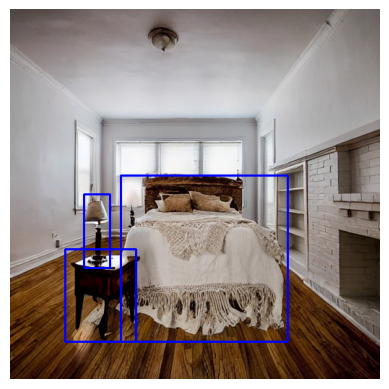

In [7]:
input_image    = load_image("./bg-for-prompt-test.jpeg")
boxes          = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases        = ["a dresser", "a lamp", "blue bed"]
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"
prompt_style   = "Rustic farmhouse furniture design, Natural wood grain, Unpolished texture, Vintage charm, Cozy aesthetics, Earthy tones"
prompt         = f'("{prompt_default}", "{prompt_style}"+).and()'

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

### 2. Mid-century Modern (Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones)

100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


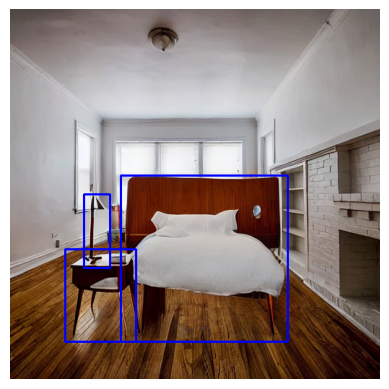

In [8]:
input_image    = load_image("./bg-for-prompt-test.jpeg")
boxes          = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases        = ["a dresser", "a lamp", "blue bed"]
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"
prompt_style   = "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones"
prompt         = f'("{prompt_default}", "{prompt_style}"+).and()'

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

### 3. Modern Minimalist (Modern minimalist furniture design in Scandinavian style, Clean lines, Neutral colors, Functional aesthetics, Metallic accents, Gray tones)

100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


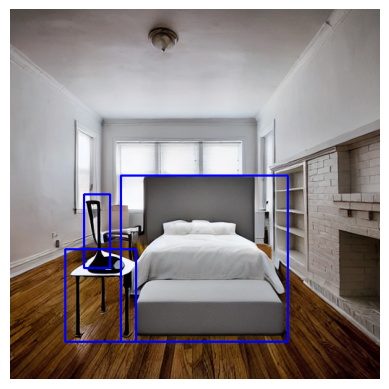

In [9]:
input_image    = load_image("./bg-for-prompt-test.jpeg")
boxes          = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases        = ["a dresser", "a lamp", "blue bed"]
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"   
prompt_style   = "Modern minimalist furniture design in Scandinavian style, Clean lines, Neutral colors, Functional aesthetics, Metallic accents, Gray tones"
prompt         = f'("{prompt_default}", "{prompt_style}"+).and()'

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

# Object Prompt 실험 (객체 3개)

Default Prompt + Style Prompt + Object Prompt -> 객체 별로도 스타일을 잘 생성할 수 있는지 실험

### 1. Blue tone++++ Bed and Orange tone++++ Lamp

단일 문장형 프롬프트에 Bed와 Lamp에 대한 정보 넣기

/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:747: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  if gligen_inpaint_image.size != (self.vae.sample_size, self.vae.sample_size):
/home/work/.conda/envs/main/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_gligen/pipeline_stable_diffusion_gligen.py:748: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  gligen_inpaint_image = self.target_size_center_crop(gligen_inpaint_image, self.vae.sample_size)
100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


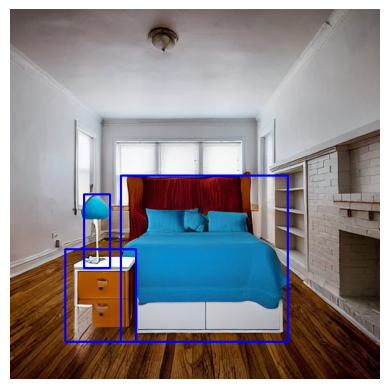

In [2]:
input_image    = load_image("./bg-for-prompt-test.jpeg")
boxes          = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases        = ["a dresser", "a lamp", "blue bed"]
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"   
prompt_style   = "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones"
prompt_object  = "Blue tone++++ Bed and Orange tone++++ Lamp"
prompt         = f'("{prompt_default}", "{prompt_style}", "{prompt_object}").and()'

positive = compel.build_conditioning_tensor(prompt)
negative = compel.build_conditioning_tensor("")
[positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

images = pipe(
    prompt_embeds          = positive,
    negative_prompt_embeds = negative,
    gligen_phrases         = phrases,
    gligen_inpaint_image   = input_image,
    gligen_boxes           = boxes,
    gligen_scheduled_sampling_beta = 1.0,
    guidance_scale                 = 7.5,
    output_type="pil",
    num_inference_steps=50,
    generator=generator
).images

visualization(input_image, images[0], boxes)

객체별 스타일 정보 전혀 반영 안됨

### 2. ["", "Orange tone++++", "Blue tone++++"]

다중 문장형 프롬프트 → 객체 별로 이미지 따로 생성 (따라서, 생성해야할 객체가 3개 있다면, Diffusion 모델을 총 3번 돌려야함)

("best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution", "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones", "").and()


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


("best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution", "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones", "Orange tone++++").and()


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


("best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution", "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones", "Blue tone++++").and()


100%|██████████| 50/50 [00:10<00:00,  4.93it/s]


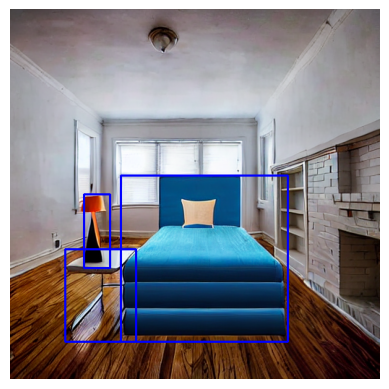

In [7]:
prompt_default = "best quality, high quality, high detail, intricate details, ultra realistic, 8k resolution"
prompt_style   = "Mid-century modern furniture design, Featuring organic shapes, Teak wood, Nostalgic, Elegant, Retro vibes, Cream tones"


def generation(image, boxes, phrases, prompt_details=""):
    prompt   = f'("{prompt_default}", "{prompt_style}", "{prompt_details}").and()'
    print(prompt)
    positive = compel.build_conditioning_tensor(prompt)
    negative = compel.build_conditioning_tensor("")
    [positive, negative] = compel.pad_conditioning_tensors_to_same_length([positive, negative])

    return pipe(
        prompt_embeds          = positive,
        negative_prompt_embeds = negative,
        gligen_inpaint_image   = image,
        gligen_phrases         = [phrases],
        gligen_boxes           = [boxes],
        gligen_scheduled_sampling_beta = 1.0,
        guidance_scale                 = 7.5,
        output_type="pil",
        num_inference_steps=50,
        generator=generator
    ).images[0]

input_image    = load_image("./bg-for-prompt-test.jpeg")
boxes          = [[0.15, 0.65, 0.34, 0.9], [0.20, 0.50, 0.27, 0.70], [0.3, 0.45, 0.75, 0.9]]
phrases        = ["a dresser", "a lamp", "a bed"]
prompt_details = ["", "Orange tone++++", "Blue tone++++"]
images = input_image.copy()

for box, phrase, prompt_detail in zip(boxes, phrases, prompt_details):
    images = generation(images, box, phrase, prompt_detail)

visualization(input_image, images, boxes)
torch.cuda.empty_cache()

이전 보다 객체 별로 스타일이 적용된걸 확인할 수 있음 → 다만 스타일 적용까지 오랜 시간이 걸릴 뿐 아니라, 적용이 안된 채로 생성이 안될 수도 있음